In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [58]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../../../Data/paths_AOA_trainData.csv')
df_test = pd.read_csv('../../../Data/paths_AOA_testData.csv')


In [59]:

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','emp', 'educ','liv','justice', 'sexorient', 'co']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['new','svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_AOA_timepoint_pre_cols = ['svc_AOA_op_7days_pre', 'svc_AOA_op_30days_pre', 'svc_AOA_op_60days_pre', 'svc_AOA_op_90days_pre',
                     'svc_AOA_es_7days_pre', 'svc_AOA_es_30days_pre', 'svc_AOA_es_60days_pre', 'svc_AOA_es_90days_pre',
                     'svc_AOA_24h_7days_pre', 'svc_AOA_24h_30days_pre', 'svc_AOA_24h_60days_pre', 'svc_AOA_24h_90days_pre',
                     'svc_AOA_ip_7days_pre', 'svc_AOA_ip_30days_pre', 'svc_AOA_ip_60days_pre', 'svc_AOA_ip_90days_pre']

output_col = ['svc_AOA_ip_90days_postdc_bi']

drop_cols = ['']

In [60]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_AOA_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_Age 60+':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['co', 'substance', 'justice', 'new']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_AOA_ip_60days_pre', 'dx_group_Depressive Disorders', 'dx_group_Schizophrenia and Other Psychotic Disorders', 'educ_Unknown/Not Reported', 'liv_Lives Independently', 'sexorient_Missing/Not Reported', 'as_loc_IPFFS', 'as_loc_IPLIHP', 'as_close_IMD/MHRC', 'as_close_Psychiatric Hospital', 'loc1_pre_None', 'co']

In [61]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [62]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [63]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [64]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [53]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    
     models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [10]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:01.686992
done
knn... Time elapsed  1:19:27.984487
done
logistic... Time elapsed  0:00:11.109243
done
mlp-nn... Time elapsed  0:03:40.017011
done
decision tree... Time elapsed  0:00:31.742990
done
random forest... Time elapsed  0:02:44.662000
done
gbm... Time elapsed  0:12:01.470000
done
Done.

Accuracy : 0.4157
Precision : 0.3948
Recall : 0.9671
F1 score : 0.5607
AUC score : 0.5281
AP score : 0.3997

Classification report : 
               precision    recall  f1-score   support

           0       0.77      0.07      0.13     12894
           1       0.39      0.97      0.56      8090

    accuracy                           0.42     20984
   macro avg       0.58      0.52      0.34     20984
weighted avg       0.63      0.42      0.29     20984


Confusion matrix : 
 [[  898 11996]
 [  266  7824]]
done.

Accuracy : 0.6124
Precision : 0.4979
Recall : 0.6518
F1 score : 0.5646
AUC score : 0.6535
AP score : 0.4974

Classification report :

(0.7222169271826153,
 0.659382489778655,
 0.5781211372064277,
 0.616083777909504,
 0.7814178718438813,
 0.7088102690598368)

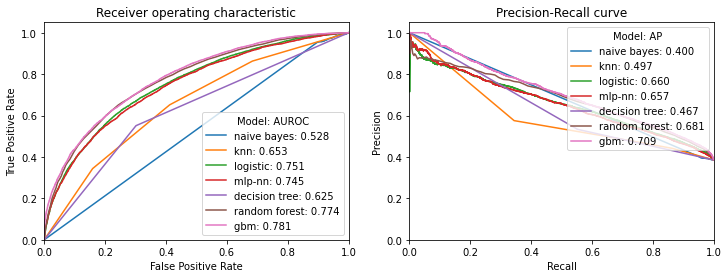

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [15]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
IP_history                                 6.525897
svc_AOA_ip_90days_pre                      2.587398
svc_AOA_es_90days_pre                      1.878956
loc5_pre_CM                                1.374952
as_close_Required Same Level\r\nof Care    1.362809
as_close_State Hospital                    1.261658
as_close_Psychiatric Hospital              1.219307
loc4_pre_TBS                               1.190108
loc5_pre_PREV                              1.154690
loc5_pre_LTCINST                           0.927517
svc_AOA_ip_30days_pre                      0.916776
loc5_pre_OPR                               0.856438
loc5_pre_RES                               0.841786
as_close_Transfer Medical Hospital         0.831630
svc_AOA_op_90days_pre                      0.787695
Name: LR, dtype: float64


In [16]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
IP_history                        0.209464
as_length_IP                      0.089613
svc_AOA_ip_90days_pre             0.064524
age                               0.061346
svc_pre_all                       0.048959
svc_pre                           0.032782
svc_AOA_es_90days_pre             0.018789
sexorient_Missing/Not Reported    0.017979
svc_AOA_op_90days_pre             0.015579
svc_AOA_op_60days_pre             0.012782
svc_AOA_es_30days_pre             0.012648
svc_AOA_es_60days_pre             0.011387
svc_AOA_op_30days_pre             0.011149
svc_pre_sub                       0.010756
liv_Lives Independently           0.010030
Name: DT, dtype: float64


In [17]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
as_length_IP                      0.068341
IP_history                        0.067910
svc_pre_all                       0.052048
age                               0.048071
svc_AOA_ip_90days_pre             0.036164
svc_pre                           0.035420
svc_AOA_ip_60days_pre             0.031848
svc_AOA_ip_30days_pre             0.023907
svc_AOA_es_90days_pre             0.022777
svc_AOA_op_90days_pre             0.021377
svc_AOA_op_60days_pre             0.019867
svc_AOA_es_60days_pre             0.018665
sexorient_Missing/Not Reported    0.017702
svc_AOA_op_30days_pre             0.016244
svc_AOA_es_30days_pre             0.015736
Name: RF, dtype: float64


In [18]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
IP_history                                              0.396292
svc_AOA_ip_90days_pre                                   0.171127
as_length_IP                                            0.124817
sexorient_Missing/Not Reported                          0.047154
liv_Lives Independently                                 0.023260
svc_AOA_ip_60days_pre                                   0.020464
as_close_IMD/MHRC                                       0.020440
svc_pre_sub                                             0.018776
as_close_Home/Shelter/Self                              0.017282
svc_AOA_ip_30days_pre                                   0.015270
dx_group_Depressive Disorders                           0.014905
dx_group_Schizophrenia and Other Psychotic Disorders    0.012924
substance                                               0.011589
gender_Male                                             0.010944
liv_Institutional                                       0.007663
Name: GBM

In [19]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,IP_history,6.525897,0.209464,0.067910,0.396292,0.224556
1,as_length_IP,-3.941111,0.089613,0.068341,0.124817,0.094257
2,svc_AOA_ip_90days_pre,2.587398,0.064524,0.036164,0.171127,0.090605
3,age,-0.441610,0.061346,0.048071,0.000709,0.036709
4,svc_pre_all,-1.372711,0.048959,0.052048,0.000261,0.033756
5,sexorient_Missing/Not Reported,-0.378621,0.017979,0.017702,0.047154,0.027611
6,svc_pre,-1.966712,0.032782,0.035420,0.001771,0.023324
7,svc_AOA_ip_60days_pre,-0.042385,0.002390,0.031848,0.020464,0.018234
8,svc_AOA_es_90days_pre,1.878956,0.018789,0.022777,0.004785,0.015450
9,liv_Lives Independently,-0.246784,0.010030,0.012457,0.023260,0.015249


In [20]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['IP_history',
 'as_length_IP',
 'svc_AOA_ip_90days_pre',
 'age',
 'svc_pre_all',
 'sexorient_Missing/Not Reported',
 'svc_pre',
 'svc_AOA_ip_60days_pre',
 'svc_AOA_es_90days_pre',
 'liv_Lives Independently',
 'svc_AOA_ip_30days_pre',
 'svc_pre_sub',
 'as_close_Home/Shelter/Self',
 'svc_AOA_op_90days_pre',
 'dx_group_Depressive Disorders']

### Fit Boruta-select variables into the models

In [30]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.197003
done
knn... Time elapsed  0:01:04.082003
done
logistic... Time elapsed  0:00:01.145992
done
mlp-nn... Time elapsed  0:03:07.660003
done
decision tree... Time elapsed  0:00:03.381010
done
random forest... Time elapsed  0:00:57.361992
done
gbm... Time elapsed  0:00:50.010009
done
Done.

Accuracy : 0.6051
Precision : 0.4923
Recall : 0.7782
F1 score : 0.6031
AUC score : 0.7134
AP score : 0.6064

Classification report : 
               precision    recall  f1-score   support

           0       0.78      0.50      0.61     12894
           1       0.49      0.78      0.60      8090

    accuracy                           0.61     20984
   macro avg       0.64      0.64      0.61     20984
weighted avg       0.67      0.61      0.61     20984


Confusion matrix : 
 [[6402 6492]
 [1794 6296]]
done.

Accuracy : 0.6429
Precision : 0.5328
Recall : 0.5984
F1 score : 0.5637
AUC score : 0.6696
AP score : 0.5168

Classification report : 
  

(0.7081585970263058,
 0.6203182374541004,
 0.6264524103831891,
 0.623370233702337,
 0.7716194450787567,
 0.6977206846466731)

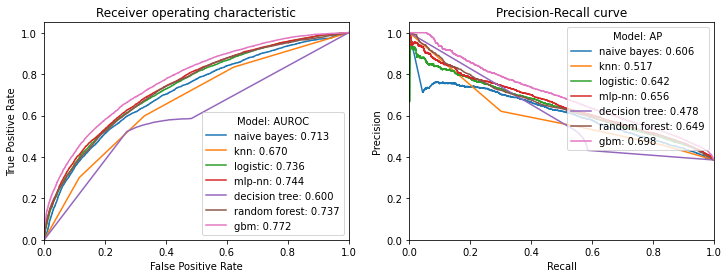

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [32]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_AOA_ip_90days_postdc_bi']


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [34]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [35]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.185005
done
knn... Time elapsed  0:00:46.143999
done
logistic... Time elapsed  0:00:01.507987
done
mlp-nn... Time elapsed  0:02:43.982003
done
decision tree... Time elapsed  0:00:03.292013
done
random forest... Time elapsed  0:00:58.022995
done
gbm... Time elapsed  0:00:59.694007
done
Done.

Accuracy : 0.6796
Precision : 0.5991
Recall : 0.5105
F1 score : 0.5513
AUC score : 0.7123
AP score : 0.6050

Classification report : 
               precision    recall  f1-score   support

           0       0.72      0.79      0.75     12894
           1       0.60      0.51      0.55      8090

    accuracy                           0.68     20984
   macro avg       0.66      0.65      0.65     20984
weighted avg       0.67      0.68      0.67     20984


Confusion matrix : 
 [[10130  2764]
 [ 3960  4130]]
done.

Accuracy : 0.6169
Precision : 0.5028
Recall : 0.5794
F1 score : 0.5384
AUC score : 0.6389
AP score : 0.4889

Classification report :

(0.5448436904308044,
 0.4535334902359901,
 0.8813349814585909,
 0.5988828692621059,
 0.709254493662598,
 0.6240985773700337)

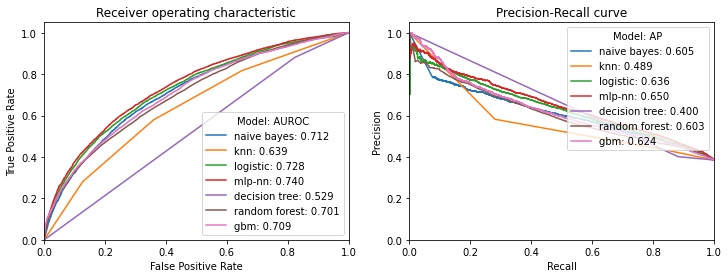

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [45]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='accuracy')

In [46]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 1000}, 0.7498811577979133)

In [47]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,n_estimators=1000, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 5}, 0.7503275694089331)

In [48]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=5, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(max_depth=5, max_features='sqrt', n_estimators=1000,
                           random_state=300)

In [49]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.7185
Precision : 0.6676
Recall : 0.5376
F1 score : 0.5956
AUC score : 0.7713
AP score : 0.7014

Classification report : 
               precision    recall  f1-score   support

           0       0.74      0.83      0.78     12894
           1       0.67      0.54      0.60      8090

    accuracy                           0.72     20984
   macro avg       0.70      0.68      0.69     20984
weighted avg       0.71      0.72      0.71     20984


Confusion matrix : 
 [[10729  2165]
 [ 3741  4349]]


as_length_IP                                            0.312059
IP_history                                              0.232106
svc_AOA_ip_60days_pre                                   0.107356
svc_pre_all                                             0.097360
svc_pre                                                 0.085928
sexorient_Missing/Not Reported                          0.029248
educ_Unknown/Not Reported                               0.025718
co                                                      0.019764
liv_Lives Independently                                 0.016701
as_close_IMD/MHRC                                       0.015150
dx_group_Depressive Disorders                           0.014370
as_loc_IPFFS                                            0.010994
dx_group_Schizophrenia and Other Psychotic Disorders    0.009851
as_loc_IPLIHP                                           0.008810
as_close_Psychiatric Hospital                           0.008040
loc1_pre_None            

Text(0, 0.5, 'Feature Importance Score')

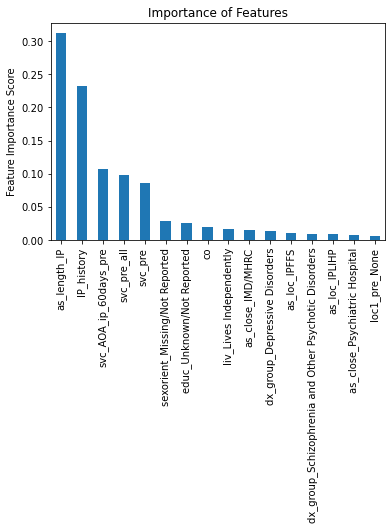

In [50]:
predictors=Xtrainb.columns
feat_imp = pd.Series(new.feature_importances_, predictors).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [65]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models["logistic"], Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances)

Fitting models.
logistic... Time elapsed  0:00:01.177993
done
Done.

as_length_IP                                           -3.925895
IP_history                                              7.130367
svc_pre_all                                            -1.239936
svc_pre                                                -2.946457
svc_AOA_ip_60days_pre                                   4.295245
dx_group_Depressive Disorders                          -0.303628
dx_group_Schizophrenia and Other Psychotic Disorders    0.173332
educ_Unknown/Not Reported                              -0.380088
liv_Lives Independently                                -0.323633
sexorient_Missing/Not Reported                         -0.398563
as_loc_IPFFS                                            0.269001
as_loc_IPLIHP                                          -0.401677
as_close_IMD/MHRC                                      -3.271422
as_close_Psychiatric Hospital                           1.556641
loc1_pre_None        

max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [ ]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

In [ ]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

In [ ]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

In [ ]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

In [ ]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''

In [ ]:
'''
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }
    '''
   